# Jupyter Notebook: Tính toán MFCC

Notebook này thực hiện tính toán các hệ số MFCC (Mel-Frequency Cepstral Coefficients) từ một file âm thanh một cách thủ công.

## Các bước thực hiện
1. **Đọc và xử lý tín hiệu âm thanh**: Đọc file WAV và chia thành các khung.
2. **Áp dụng cửa sổ Hamming**: Giảm hiệu ứng rìa khi tính FFT.
3. **Tính phổ năng lượng**: Sử dụng FFT để chuyển đổi tín hiệu sang miền tần số.
4. **Tạo filterbank Mel**: Xây dựng các bộ lọc tam giác dựa trên thang Mel.
5. **Tính MFCC**: Áp dụng logarit và DCT để lấy các hệ số MFCC.
6. **Trực quan hóa**: Vẽ biểu đồ tín hiệu, heatmap MFCC, và biểu đồ cột cho vector trung bình.

In [11]:
# Import các thư viện cần thiết
import numpy as np
from scipy.fftpack.realtransforms import dct
import librosa
import scipy.signal
import matplotlib.pyplot as plt

# Định nghĩa số hệ số MFCC mặc định
LEN = 13

## Giải thích thuật toán của `triangular_filter_bank`

Hàm `triangular_filter_bank` tạo ra **bộ lọc tam giác trên trục tần số Mel**, mô phỏng cách con người cảm nhận âm thanh.  
Đây là bước tiền xử lý quan trọng trong việc trích xuất đặc trưng **MFCC (Mel-Frequency Cepstral Coefficients)**.


1. **Tạo số lượng bộ lọc cần thiết**
   - Bao gồm `lin_filt` bộ lọc tuyến tính và `log_filt` bộ lọc logarit.

2. **Tính các tần số đặc trưng**
   - Các điểm biên và đỉnh của tam giác được tính bằng quy luật:
     - Tuyến tính: tăng đều mỗi `linc` Hz.
     - Logarit: tăng theo cấp số nhân với cơ số `logsc`.

3. **Tính chiều cao của mỗi tam giác**
   - Đảm bảo mỗi bộ lọc có tổng diện tích chuẩn hóa.

4. **Duyệt từng bộ lọc để gán giá trị**
   - Với mỗi tam giác, xác định vùng ảnh hưởng theo FFT bins.
   - Gán hệ số tăng dần từ chân trái đến đỉnh và giảm dần từ đỉnh đến chân phải.

5. **Trả về**
   - `fbank`: Ma trận chứa hệ số của các bộ lọc ứng với mỗi bin FFT.
   - `freqs`: Các tần số xác định các bộ lọc (chân trái, đỉnh, chân phải).

In [12]:
# Hàm tạo bộ lọc tam giác trên trục tần số Mel
def triangular_filter_bank(fs, nfft, lowfreq=133.33, linc=200/3, logsc=1.0711703, lin_filt=LEN, log_filt=27):
    num_filts = lin_filt + log_filt  # Tổng số bộ lọc (tuyến tính + logarit)

    # Số lượng bins tần số từ FFT (do chỉ lấy tần số dương)
    nfreq_bins = nfft // 2 + 1

    # Xác định các điểm đặc trưng của bộ lọc (chân trái, đỉnh, chân phải)
    freqs = np.zeros(num_filts + 2)  # +2 vì có thêm biên ngoài cùng
    freqs[0:lin_filt] = lowfreq + np.arange(lin_filt) * linc  # Các tần số tăng tuyến tính
    freqs[lin_filt:] = freqs[lin_filt - 1] * logsc ** np.arange(1, log_filt + 3)  # Các tần số tăng logarit

    # Chiều cao của tam giác để mỗi bộ lọc có tổng diện tích = 1
    heights = 2.0 / (freqs[2:] - freqs[:-2])  # f_high - f_low cho từng bộ lọc

    # Khởi tạo ma trận filterbank (num_filts x nfreq_bins)
    fbank = np.zeros((num_filts, nfreq_bins))
    
    # Tạo mảng tần số tương ứng với các bin FFT từ 0 đến fs/2
    nfreqs = np.linspace(0, fs / 2, nfreq_bins)

    # Duyệt qua từng bộ lọc để xây dựng hình tam giác
    for i in range(num_filts):
        f_low = freqs[i]
        f_center = freqs[i + 1]
        f_high = freqs[i + 2]

        # Tìm vị trí bin gần nhất với các tần số đặc trưng
        left_bin = np.searchsorted(nfreqs, f_low)
        center_bin = np.searchsorted(nfreqs, f_center)
        right_bin = np.searchsorted(nfreqs, f_high)

        # Tạo sườn trái của tam giác
        for j in range(left_bin, center_bin):
            if j < nfreq_bins:
                fbank[i, j] = heights[i] * (nfreqs[j] - f_low) / (f_center - f_low)

        # Tạo sườn phải của tam giác
        for j in range(center_bin, right_bin):
            if j < nfreq_bins:
                fbank[i, j] = heights[i] * (f_high - nfreqs[j]) / (f_high - f_center)

    return fbank, freqs  # Trả về ma trận filterbank và các tần số đặc trưng

## Giải thích thuật toán của `compute_mfcc`

Hàm này chuyển đổi phổ tần số (sau FFT) thành đặc trưng MFCC 

1. **Tính Mel Spectrum**:
   - Nhân `fft_magnitude` (phổ FFT) với `filterbank.T` để gộp năng lượng theo các dải tần Mel.
   - Dùng `log10` để nén động độ lớn, mô phỏng tai người (vì tai người cảm nhận cường độ theo thang logarit).

2. **Tính MFCC bằng DCT (Discrete Cosine Transform)**:
   - DCT loại II được áp dụng lên Mel Spectrum để loại bỏ tương quan và làm nổi bật đặc trưng.
   - Chỉ lấy `num_mfcc_feats` đầu tiên (thường là 12 hoặc 13 hệ số) để giảm nhiễu và giữ thông tin quan trọng.

In [13]:
# Hàm tính MFCC cho một khung tín hiệu
def compute_mfcc(fft_magnitude, fbank, num_mfcc_feats):
    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + 1e-8)
    ceps = dct(mspec, type=2, norm="ortho", axis=-1)[:num_mfcc_feats]
    return ceps

## Giải thích thuật toán của `get_mfcc`

Hàm `get_mfcc` dùng để trích xuất đặc trưng MFCC (Mel-Frequency Cepstral Coefficients) từ một tín hiệu âm thanh hoặc một khung tín hiệu đã xử lý FFT.  

1. **Tạo Mel Filterbank**  
   Sử dụng hàm `triangular_filter_bank` để tạo ra một tập các bộ lọc tam giác mô phỏng thang cảm nhận tần số của tai người.  
   Các bộ lọc này sẽ được dùng để gom năng lượng của tín hiệu vào các dải tần tương ứng trên thang Mel.

2. **Tính toán MFCC**  
   Gọi hàm `compute_mfcc` để thực hiện:
   - Nhân phổ FFT với Mel filterbank → Mel spectrum.
   - Lấy log của phổ Mel → nén động độ lớn.
   - Áp dụng DCT → khử tương quan → lấy các hệ số MFCC đầu tiên.

In [14]:
# Hàm trích xuất MFCC cho toàn bộ tín hiệu
def get_mfcc(fs, nfft, n_mfcc_feats, signal):
    [fbank, freqs] = triangular_filter_bank(fs, nfft)
    feature = compute_mfcc(signal, fbank, n_mfcc_feats)
    return feature

## Giải thích thuật toán của `mfcc_function`

Hàm `mfcc_function` trích xuất đặc trưng MFCC (Mel-Frequency Cepstral Coefficients) từ một file âm thanh đầu vào.

1. **Đọc âm thanh**  
   Sử dụng `librosa.load` để đọc file âm thanh thành một vector mẫu `y` và lấy mẫu ở tần số `sr` (mặc định 16kHz).

2. **Chia khung tín hiệu (Framing)**  
   Tín hiệu được chia thành các khung dài 25ms, dịch mỗi 10ms, tương đương `frame_length_samples` và `hop_length_samples`.

3. **Áp dụng cửa sổ Hamming**  
   Giảm hiện tượng rò rỉ phổ bằng cách nhân từng khung với cửa sổ Hamming.

4. **Tính FFT và phổ công suất**  
   Sử dụng FFT để chuyển khung tín hiệu sang miền tần số và lấy bình phương biên độ (power spectrum).

5. **Tính MFCC từng khung**  
   Với mỗi khung:
   - Nếu là khung lặng (năng lượng thấp), gán vector MFCC bằng 0.
   - Nếu không, tính MFCC bằng hàm `get_mfcc`.

6. **Tính trung bình MFCC của các khung không lặng**  
   Tính vector MFCC đại diện cho toàn bộ file bằng cách lấy trung bình các khung không lặng.

7. **Chuẩn hóa MFCC**  
   Thực hiện chuẩn hóa để tăng độ phân biệt, giảm ảnh hưởng của môi trường.

8. **Trả về kết quả**  
   - `mfcc_mean`: vector MFCC trung bình.
   - `mfcc_features`: ma trận MFCC (số hệ số × số khung).
   - `mfcc_features_normalized`: MFCC đã chuẩn hóa, thích hợp cho trực quan hóa hoặc đưa vào mô hình học máy.

In [15]:
def mfcc_function(file_path, sr=44100, frame_length=0.025, hop_length=0.0125, n_mfcc=13, nfft=1024):
    # Đọc tín hiệu âm thanh
    y, sr = librosa.load(file_path, sr=sr)
    duration = len(y) / sr
    print(f"File âm thanh: {duration:.2f} giây, số mẫu: {len(y)}")

    # Chia khung
    frame_length_samples = int(frame_length * sr)  # 1024 mẫu
    hop_length_samples = int(hop_length * sr)     # 512 mẫu
    frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=hop_length_samples).T.copy()
    num_frames = frames.shape[0]
    print(f"Số khung: {num_frames}")

    # Áp dụng cửa sổ Hamming
    window = scipy.signal.get_window("hamming", frame_length_samples)
    frames *= window

    # Tính FFT magnitude
    fft_magnitude = np.abs(np.fft.rfft(frames, n=nfft, axis=1)) ** 2

    # Tính MFCC cho tất cả khung
    mfcc_features = np.zeros((num_frames, n_mfcc))
    for i in range(num_frames):
        if np.sum(fft_magnitude[i, :]) < 1e-6:
            mfcc_features[i, :] = 0
        else:
            mfcc_features[i, :] = get_mfcc(sr, nfft, n_mfcc, fft_magnitude[i, :])

    # Xác định các khung không lặng
    non_silent_indices = np.where(np.sum(fft_magnitude, axis=1) >= 1e-6)[0]
    print(f"Số khung không lặng: {len(non_silent_indices)}")

    # Chuẩn hóa MFCC về (-1, 1) cho tất cả khung (kể cả lặng)
    mfcc_features_normalized = np.zeros_like(mfcc_features)
    if len(non_silent_indices) > 0:
        non_silent_mfcc = mfcc_features[non_silent_indices, :]
        
        # Tính min/max cho từng hệ số MFCC
        min_vals = np.min(non_silent_mfcc, axis=0, keepdims=True)
        max_vals = np.max(non_silent_mfcc, axis=0, keepdims=True)
        ranges = max_vals - min_vals + 1e-8
        
        # Chuẩn hóa các khung không lặng
        normalized = 2 * (non_silent_mfcc - min_vals) / ranges - 1
        normalized = np.clip(normalized, -1.0, 1.0)
        
        # Gán giá trị đã chuẩn hóa
        mfcc_features_normalized[non_silent_indices, :] = normalized

    # Tính vector trung bình từ dữ liệu ĐÃ CHUẨN HÓA
    if len(non_silent_indices) > 0:
        mfcc_mean_normalized = np.mean(mfcc_features_normalized[non_silent_indices, :], axis=0)
    else:
        mfcc_mean_normalized = np.zeros(n_mfcc)

    # Chuyển vị ma trận
    return mfcc_mean_normalized, mfcc_features_normalized.T, mfcc_features_normalized.T

## Giải thích thuật toán của `plot_mfcc_heatmap`

Hàm `plot_mfcc_heatmap` dùng để trực quan hóa đặc trưng MFCC theo thời gian dưới dạng biểu đồ heatmap, giúp dễ dàng quan sát biến thiên của các hệ số MFCC trong quá trình phát âm.

- Input `mfcc_features`: ma trận MFCC kích thước (số hệ số MFCC × số khung).
- `hop_length`: khoảng thời gian dịch khung (tính bằng giây).
- `sr`: tần số lấy mẫu (không dùng trực tiếp trong hàm này nhưng thường cần để tính hop_length).
- `title`: tiêu đề biểu đồ.

In [16]:
# Hàm vẽ heatmap MFCC
def plot_mfcc_heatmap(mfcc_features, hop_length, sr, title="Hình. Minh họa MFCCs"):
    """
    Vẽ heatmap MFCC trên tất cả các khung.
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc_features, aspect='auto', origin='lower', cmap='jet', interpolation='nearest')
    plt.colorbar(label='Hệ số MFCC')

    # Đặt nhãn trục x (Thời gian)
    num_frames = mfcc_features.shape[1]
    time_axis = np.arange(num_frames) * hop_length
    plt.xticks(ticks=np.linspace(0, num_frames-1, 5), labels=np.round(np.linspace(0, time_axis[-1], 5), 2))
    plt.xlabel('Thời gian (s)')

    # Đặt nhãn trục y (giá trị MFCC)
    plt.ylabel('Hệ số MFCC')
    plt.ylim(-0.5, 12.5)  # Đảm bảo hiển thị đầy đủ 13 hệ số

    plt.title(title)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `plot_mfcc_mean`

Hàm `plot_mfcc_mean` dùng để trực quan hóa vector MFCC trung bình dưới dạng biểu đồ cột, giúp người dùng dễ dàng so sánh và nhận biết các giá trị đặc trưng âm thanh trung bình của từng hệ số MFCC.

- Input `mfcc_mean`: vector 1 chiều chứa giá trị MFCC trung bình trên tất cả các khung.
- Hàm sẽ tạo một biểu đồ cột, mỗi cột tương ứng với một hệ số MFCC.
- Trục x đánh số các hệ số MFCC từ 0 đến n-1 và gán nhãn 'MFCC0', 'MFCC1', ...
- Trục y biểu diễn giá trị trung bình của từng hệ số.
- Lưới ngang được thêm vào để hỗ trợ quan sát trực quan các giá trị.

In [17]:
# Hàm vẽ biểu đồ cột cho vector MFCC trung bình
def plot_mfcc_mean(mfcc_mean, title="Biểu đồ Vector MFCC Trung bình"):
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(mfcc_mean)), mfcc_mean, color='skyblue')
    plt.xlabel('Hệ số MFCC')
    plt.ylabel('Giá trị MFCC trung bình')
    plt.title(title)
    plt.xticks(range(len(mfcc_mean)), [f'MFCC{i}' for i in range(len(mfcc_mean))])
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `plot_signal`

Hàm `plot_signal` dùng để hiển thị đồ thị biểu diễn tín hiệu âm thanh theo thời gian, giúp ta hình dung đặc tính dao động biên độ của âm thanh trong suốt thời gian thu.

- Input:
  - `y`: mảng chứa mẫu tín hiệu âm thanh (biên độ).
  - `sr`: tần số lấy mẫu (sampling rate) đơn vị Hz.
- Trục hoành (x) được tính là số mẫu chia cho tần số lấy mẫu, ra đơn vị thời gian tính bằng giây.
- Trục tung (y) là giá trị biên độ của tín hiệu tại từng thời điểm.
- Đồ thị vẽ nối các điểm theo thứ tự thời gian để biểu diễn dao động của tín hiệu âm thanh.
- Hiển thị lưới để dễ theo dõi xu hướng tín hiệu.

In [18]:
# Hàm vẽ tín hiệu âm thanh
def plot_signal(y, sr, title="Tín hiệu âm thanh"):
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(len(y)) / sr, y)
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Giải thích thuật toán của `test_mfcc`

- Đọc file âm thanh và vẽ tín hiệu ban đầu.
- Tính MFCC bằng hàm mfcc_function.
- In giá trị min, max và vector trung bình của MFCC.
- Vẽ heatmap và biểu đồ cột để trực quan hóa kết quả.

In [19]:
def test_mfcc(file_path):
    """
    Hàm test MFCC với một file âm thanh.
    """
    try:
        # Đọc tín hiệu âm thanh để kiểm tra
        y, sr = librosa.load(file_path, sr=44100)
        plot_signal(y, sr)

        # Tính MFCC
        mfcc_mean, mfcc_features, mfcc_features_normalized = mfcc_function(file_path)

        # Kiểm tra giá trị
        print("Giá trị MFCC đã chuẩn hóa (min, max):", 
              np.min(mfcc_features_normalized), 
              np.max(mfcc_features_normalized))
        print("Vector MFCC trung bình (đã chuẩn hóa):", mfcc_mean)

        # Vẽ heatmap MFCC (dùng bản đã chuẩn hóa để tăng độ tương phản)
        plot_mfcc_heatmap(mfcc_features_normalized, hop_length=0.0125, sr=44100)

        # Vẽ biểu đồ cột cho vector MFCC trung bình
        plot_mfcc_mean(mfcc_mean)

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file âm thanh '{file_path}'.")
    except Exception as e:
        print(f"Lỗi xảy ra: {str(e)}")

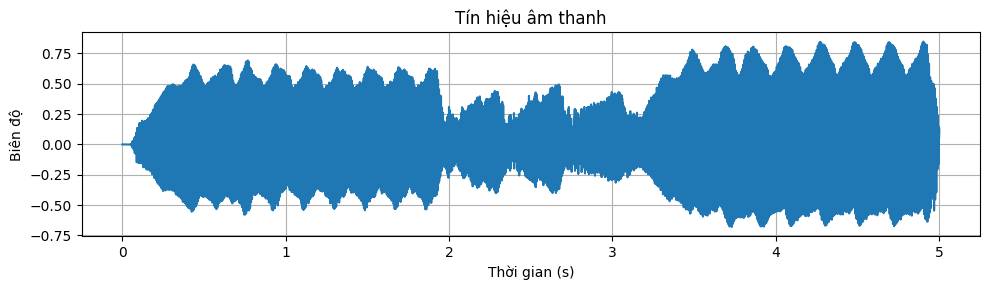

File âm thanh: 5.00 giây, số mẫu: 220500
Số khung: 399
Số khung không lặng: 396
Giá trị MFCC đã chuẩn hóa (min, max): -1.0 0.9999999990936186
Vector MFCC trung bình (đã chuẩn hóa): [ 0.81241618  0.44686026  0.04174402  0.18326054  0.0927813  -0.08059339
 -0.0972686   0.20061995  0.09762517  0.04708289 -0.05200958 -0.01617558
 -0.19676487]


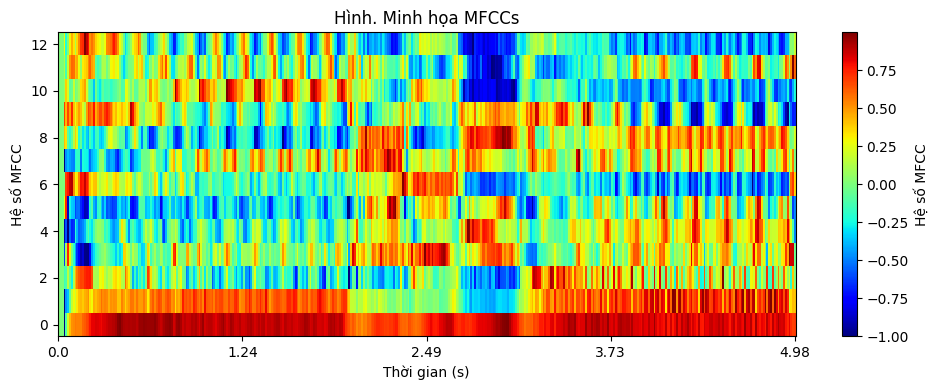

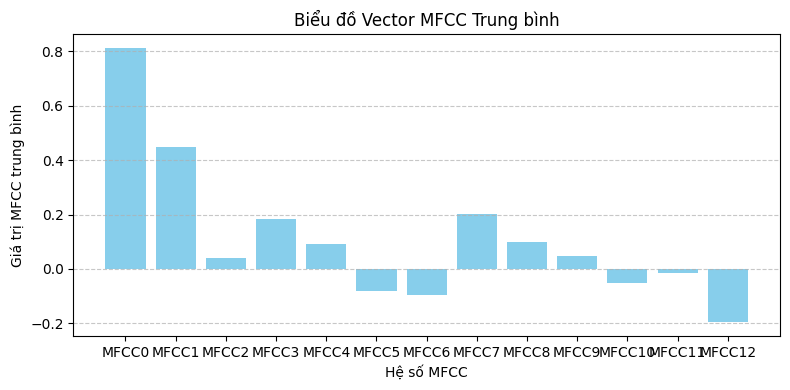

In [20]:
# Chạy thử với file âm thanh
file_path = "sound-fixed_Cello_F1-Arioso_in_C_for_Cello_Solo.wav"  # Thay bằng đường dẫn file âm thanh của bạn
test_mfcc(file_path)